<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/AffectiveRoad_Preprocessing_Cross_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample
from scipy.signal import find_peaks
import scipy.signal

In [ ]:
zip_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data_w1dqSB9.zip"
extract_to = "/content/drive/MyDrive/AffectiveRoad Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/E4"
print("Esiste?", os.path.exists(base_path))  # Deve stampare: True

Esiste? True


In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/E4"

for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

E4/
    .DS_Store
    Annot_E4_Left.csv
    Annot_E4_Right.csv
    4-E4-Drv4/
        Left.zip
        Right.zip
        unzipped_Left/
            ACC.csv
            EDA.csv
            BVP.csv
            TEMP.csv
            IBI.csv
            tags.csv
            info.txt
            HR.csv
    5-E4-Drv5/
        Right.zip
        Left.zip
        unzipped_Left/
            ACC.csv
            EDA.csv
            tags.csv
            info.txt
            IBI.csv
            TEMP.csv
            HR.csv
            BVP.csv
    9-E4-Drv9/
        Right.zip
        Left.zip
        unzipped_Left/
            EDA.csv
            ACC.csv
            info.txt
            TEMP.csv
            HR.csv
            BVP.csv
            IBI.csv
            tags.csv
    1-E4-Drv1/
        Right.zip
        Left.zip
        unzipped_Left/
            IBI.csv
            EDA.csv
            ACC.csv
            BVP.csv
            TEMP.csv
            tags.csv
            info.txt
            HR.c

In [ ]:
def parse_numeric_value(x):
    """
    Pulisce una stringa con più punti nel numero, mantenendo solo il primo come separatore decimale.
    """
    try:
        if isinstance(x, str):
            x = x.strip().replace(' ', '')  # Rimuove spazi
            if x.count('.') > 1:
                parts = x.split('.')
                return float(parts[0] + '.' + ''.join(parts[1:]))
            return float(x)
        return float(x)
    except:
        return np.nan

In [ ]:
def load_affectiveroad_data(base_path, target_freq=64):
    """
    Carica ed effettua upsampling dei dati Empatica E4 per tutti i soggetti in AffectiveROAD Dataset.
    """
    signal_files = ['ACC.csv', 'BVP.csv', 'EDA.csv', 'TEMP.csv']
    all_data = []

    subject_folders = sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d)) and d.endswith("-E4-Drv" + d.split("-")[0])
        or d.startswith(tuple([f"{i}-E4-Drv" for i in range(1, 14)]))
    ])

    for folder in subject_folders:
        subject_path = os.path.join(base_path, folder)
        zip_names = [f for f in os.listdir(subject_path) if f.startswith("Left") and f.endswith(".zip")]

        for zip_name in zip_names:
            with zipfile.ZipFile(os.path.join(subject_path, zip_name), 'r') as zip_ref:
                zip_ref.extractall(subject_path + "/unzipped_" + zip_name.split(".")[0])

        unzipped_folders = [os.path.join(subject_path, d) for d in os.listdir(subject_path) if d.startswith("unzipped_")]

        for unzip_dir in unzipped_folders:
            signals = {}

            for signal_file in signal_files:
                file_path = os.path.join(unzip_dir, signal_file)
                if not os.path.exists(file_path):
                    continue

                try:
                    raw_data = pd.read_csv(file_path, skiprows=2, header=None)
                    for col in raw_data.columns:
                        raw_data[col] = raw_data[col].map(parse_numeric_value)

                    # Frequenze originali
                    freq_map = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4}
                    orig_freq = freq_map[signal_file.split('.')[0]]
                    n_samples = int(len(raw_data) * target_freq / orig_freq)

                    resampled = resample(raw_data.values, n_samples, axis=0)

                    if signal_file == 'ACC.csv':
                        signals['acc1'] = resampled[:, 0]
                        signals['acc2'] = resampled[:, 1]
                        signals['acc3'] = resampled[:, 2]
                    else:
                        signals[signal_file.split('.')[0].lower()] = resampled.squeeze()
                except Exception as e:
                    print(f"Errore su {file_path}: {e}")
                    continue

            # Allinea lunghezza
            min_len = min(len(sig) for sig in signals.values())
            for k in signals:
                signals[k] = signals[k][:min_len]

            df = pd.DataFrame(signals)
            df["subject"] = folder.split("-")[-1]  # Es. 'Drv1'
            all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/E4"
df = load_affectiveroad_data(base_path, target_freq=64)

In [ ]:
print("Shape of AffectiveRoadDataset:", df.shape)
df.head()

Shape of AffectiveRoadDataset: (5693652, 7)


,acc1,acc2,acc3,bvp,eda,temp,subject
0,7.000000,-44.000000,45.000000,-3.439623e-14,3.026075e-15,382.180000,Drv1
1,11.999693,-53.519621,44.413727,-1.656125e-14,-2.061213e-01,399.175096,Drv1
2,7.000000,-42.000000,46.000000,2.038345e-14,-3.672994e-01,413.836202,Drv1
3,-0.196511,-34.550733,47.149869,-3.567041e-14,-4.830911e-01,426.002278,Drv1
4,-4.000000,-40.000000,47.000000,-1.273737e-14,-5.540607e-01,435.565582,Drv1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693652 entries, 0 to 5693651
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   acc1     float64
 1   acc2     float64
 2   acc3     float64
 3   bvp      float64
 4   eda      float64
 5   temp     float64
 6   subject  object 
dtypes: float64(6), object(1)
memory usage: 304.1+ MB


In [ ]:
df.describe()

,acc1,acc2,acc3,bvp,eda,temp
count,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06
mean,-2.700631e+01,-1.037054e+01,3.556739e+01,-5.428502e-05,5.320919e+00,3.382515e+01
std,2.711127e+01,2.529767e+01,2.585755e+01,9.477823e+01,5.395179e+00,4.445436e+00
min,-2.023257e+02,-1.720794e+02,-1.692707e+02,-2.089750e+03,-2.969124e+00,-1.070650e+01
25%,-4.807159e+01,-3.000000e+01,2.100000e+01,-2.630000e+01,1.508182e+00,3.228942e+01
50%,-2.800000e+01,-9.090761e+00,4.392683e+01,2.130000e+00,3.923683e+00,3.365961e+01
75%,-1.200000e+01,5.844741e+00,5.591472e+01,3.016000e+01,6.932137e+00,3.545296e+01
max,2.024553e+02,1.745994e+02,1.668622e+02,2.087630e+03,2.802013e+01,4.494678e+02


In [ ]:
df['subject'].value_counts()

,count
subject,
Drv10,572928
Drv2,458688
Drv11,456384
Drv5,444768
Drv6,438912
Drv13,436864
Drv3,429056
Drv7,424832
Drv8,420992


In [ ]:
def load_subjective_metrics(base_path):
    """
    Carica i file SM_Drvx.csv contenenti le metriche soggettive,
    aggiungendo le colonne 'stress_ratio' e 'Subject'.
    """
    all_data = []

    for i in range(1, 14):  # Drv1 a Drv13
        file_name = f"SM_Drv{i}.csv"
        file_path = os.path.join(base_path, file_name)

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            if df.shape[1] == 1:
                df.columns = ['stress_ratio']
            else:
                print(f"[ATTENZIONE] Struttura inattesa in {file_name}: {df.columns.tolist()}")
                continue

            df['Subject'] = f'Drv{i}'
            all_data.append(df)
        else:
            print(f"[ATTENZIONE] File non trovato: {file_path}")

    return pd.concat(all_data, ignore_index=True)

In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/Subj_metric"
subjective_metrics = load_subjective_metrics(base_path)

In [ ]:
print("Shape of Subjective Metric:", subjective_metrics.shape)
subjective_metrics.head()

Shape of Subjective Metric: (194568, 2)


,stress_ratio,Subject
0,0.0,Drv1
1,0.0,Drv1
2,0.0,Drv1
3,0.0,Drv1
4,0.0,Drv1


In [ ]:
def label_protocol_phases(subjective_metrics, annotation_csv_path):
    import pandas as pd

    # Carica le annotazioni
    annotation_df = pd.read_csv(annotation_csv_path)
    subjective_metrics['Protocol'] = None  # Reset colonna

    for _, row in annotation_df.iterrows():
        subject_id = row['Drive_id']
        subj_mask = subjective_metrics['Subject'] == subject_id
        subj_data = subjective_metrics[subj_mask].copy()

        # Crea lista delle fasi del protocollo
        phases = [
            ('Z', row['Z_Start'], row['Z_End']),
            ('City1', row['City1_Start'], row['City1_End']),
            ('Hwy', row['Hwy_Start'], row['Hwy_End']),
            ('City2', row['City2_Start'], row['City2_End']),
            ('City2_2', row['City2_Start.1'], row['City2_End.1']),
            ('Hwy_2', row['Hwy_Start.1'], row['Hwy_End.1']),
        ]

        # Filtra solo fasi valide (non NaN)
        valid_phases = [(name, int(start), int(end)) for name, start, end in phases if pd.notna(start) and pd.notna(end)]
        valid_phases.sort(key=lambda x: x[1])  # Ordina per indice di inizio

        # Etichettatura delle fasi principali
        for name, start, end in valid_phases:
            indices = subj_data.iloc[start:end+1].index
            subjective_metrics.loc[indices, 'Protocol'] = name

        # Etichettatura delle fasi di transizione
        for i in range(len(valid_phases) - 1):
            prev_end = valid_phases[i][2]
            next_start = valid_phases[i + 1][1]

            if next_start > prev_end + 1:
                trans_label = f'Transition{i + 1}'
                indices = subj_data.iloc[prev_end + 1:next_start].index
                subjective_metrics.loc[indices, 'Protocol'] = trans_label

    return subjective_metrics

In [ ]:
annotation_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/Subj_metric/Annot_Subjective_metric.csv"

subjective_metrics = label_protocol_phases(subjective_metrics, annotation_path)

In [ ]:
# Raggruppa per soggetto e tratto
grouped = subjective_metrics.reset_index().groupby(['Subject', 'Protocol'])['index']

# Calcola min e max per ogni blocco
phase_ranges = grouped.agg(Start_Index='min', End_Index='max', N_Samples='count')

# Mostra il risultato
pd.set_option('display.max_rows', 100)  # Aumenta se hai molti soggetti
display(phase_ranges)

Start_Index  End_Index  N_Samples
Subject Protocol                                      
Drv1    City1                624       1736       1113
        City2               4056       6628       2573
        City2_2             6936       8892       1957
        Hwy                 2416       3536       1121
        Hwy_2               9004      10232       1229
...                          ...        ...        ...
Drv9    Transition2       104718     105196        479
        Transition3       106262     106632        371
        Transition4       108478     108876        399
        Transition5       110858     110964        107
        Z                 103130     103577        448

[143 rows x 3 columns]

In [ ]:
def plot_stress_by_protocol_line(subjective_metrics, subjects=None):
    import matplotlib.pyplot as plt

    # Se non specificato, usa tutti i soggetti
    if subjects is None:
        subjects = subjective_metrics['Subject'].unique()

    # Ordine dei protocolli per consistenza visiva
    protocol_order = ['Z', 'Transition1', 'City1', 'Transition2', 'Hwy', 'Transition3',
                      'City2', 'Transition4', 'City2_2', 'Transition5', 'Hwy_2']

    for subj in subjects:
        df_subj = subjective_metrics[subjective_metrics['Subject'] == subj].copy()
        df_subj = df_subj.reset_index()

        plt.figure(figsize=(16, 4))
        ax = plt.gca()

        for prot in df_subj['Protocol'].dropna().unique():
            prot_df = df_subj[df_subj['Protocol'] == prot]
            if not prot_df.empty:
                ax.plot(prot_df['index'], prot_df['stress_ratio'], label=prot)
                ax.fill_between(prot_df['index'], prot_df['stress_ratio'], alpha=0.3)

        ax.set_title(f'Stress Ratio over Time – Subject {subj}')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Stress Ratio')
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

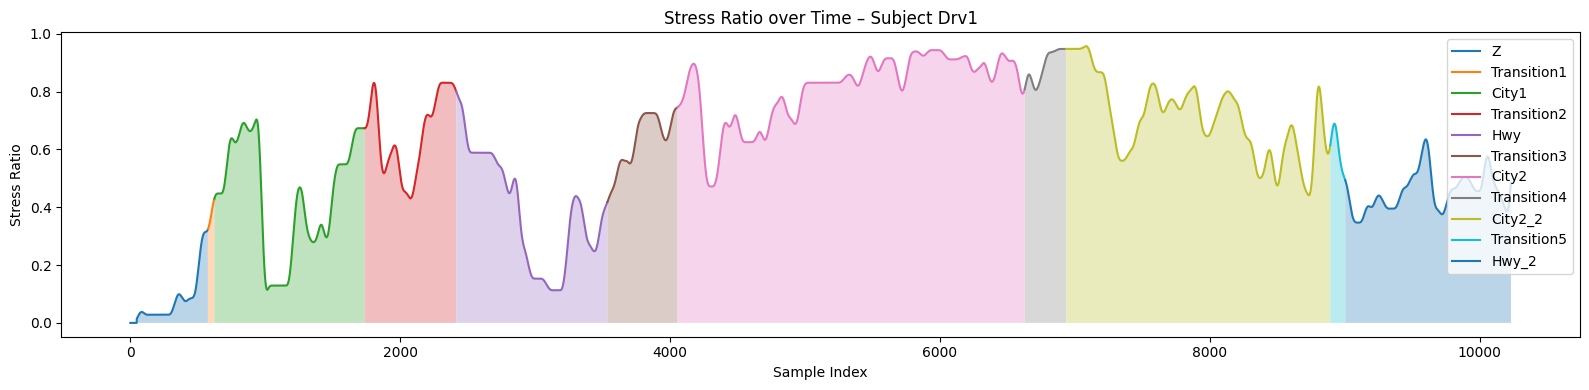

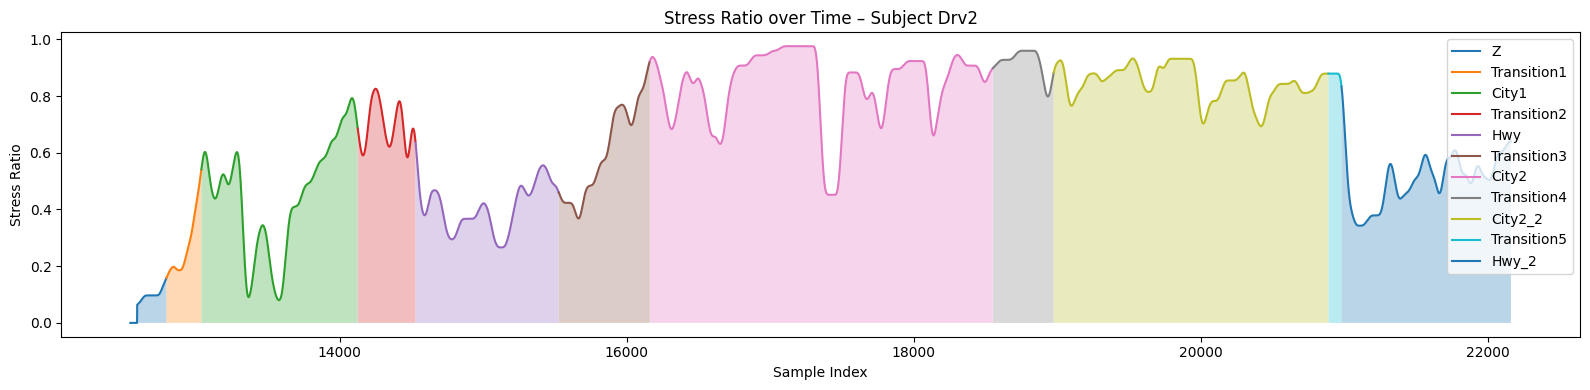

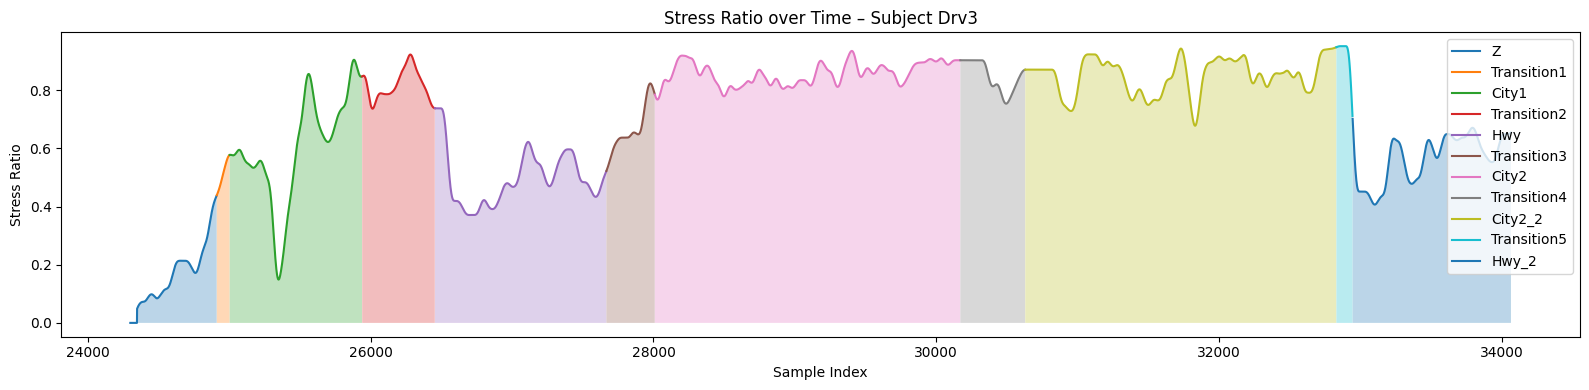

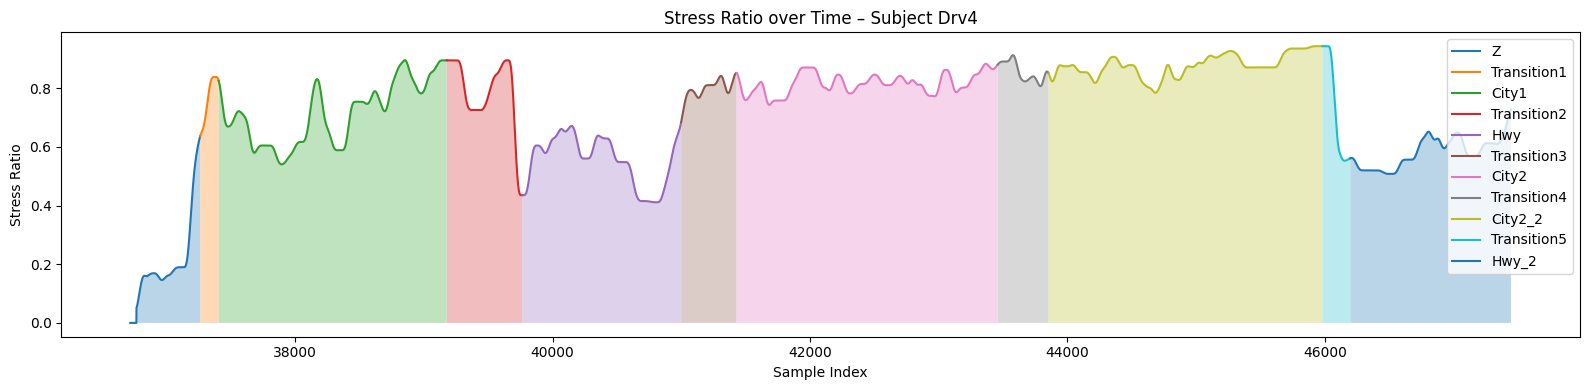

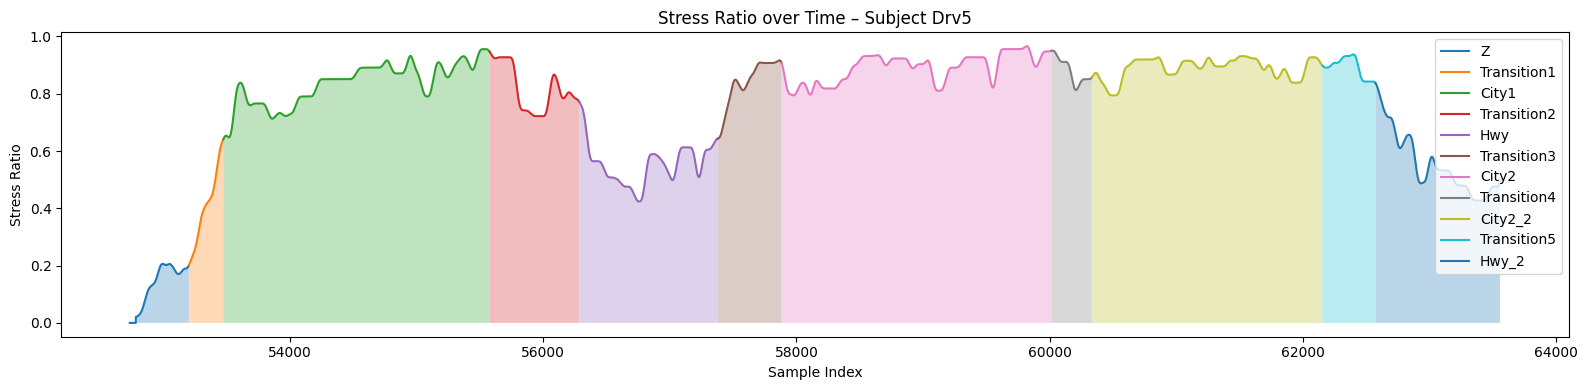

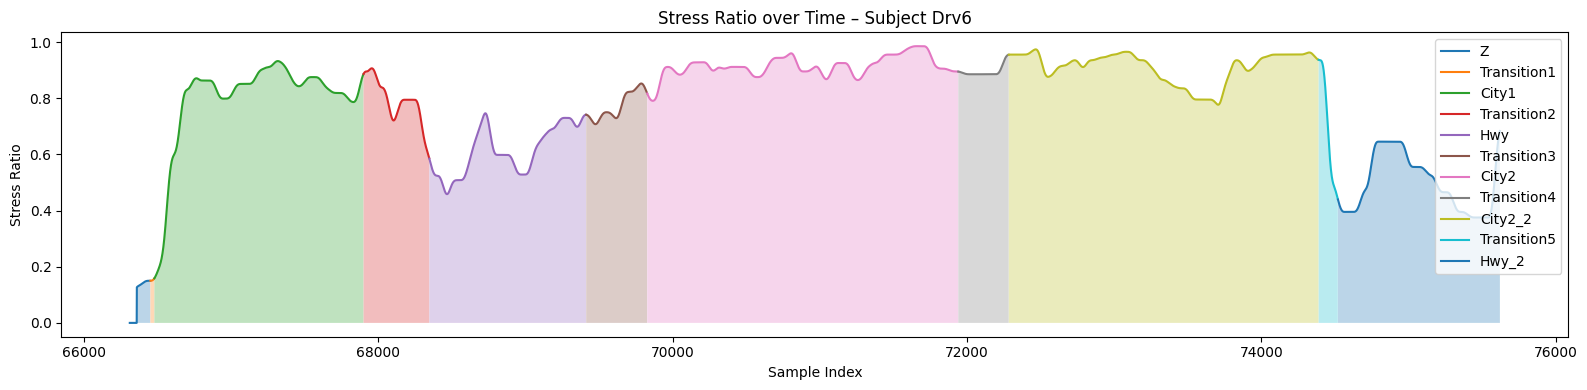

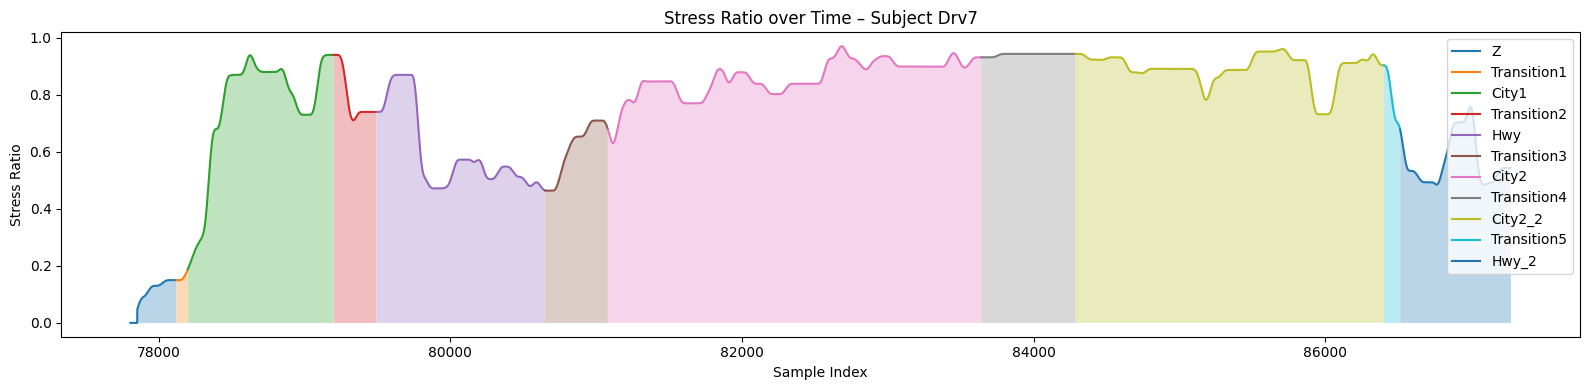

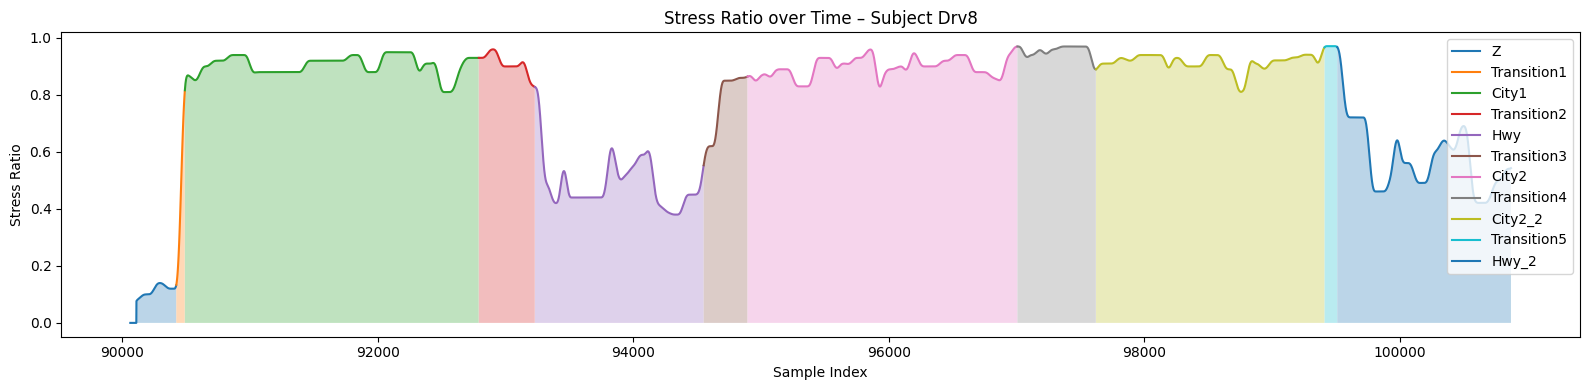

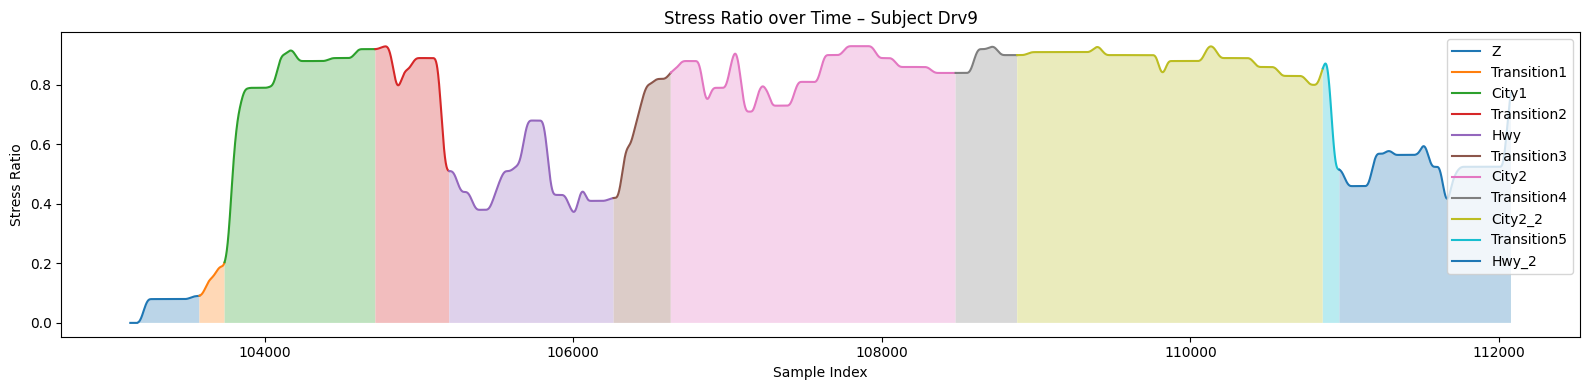

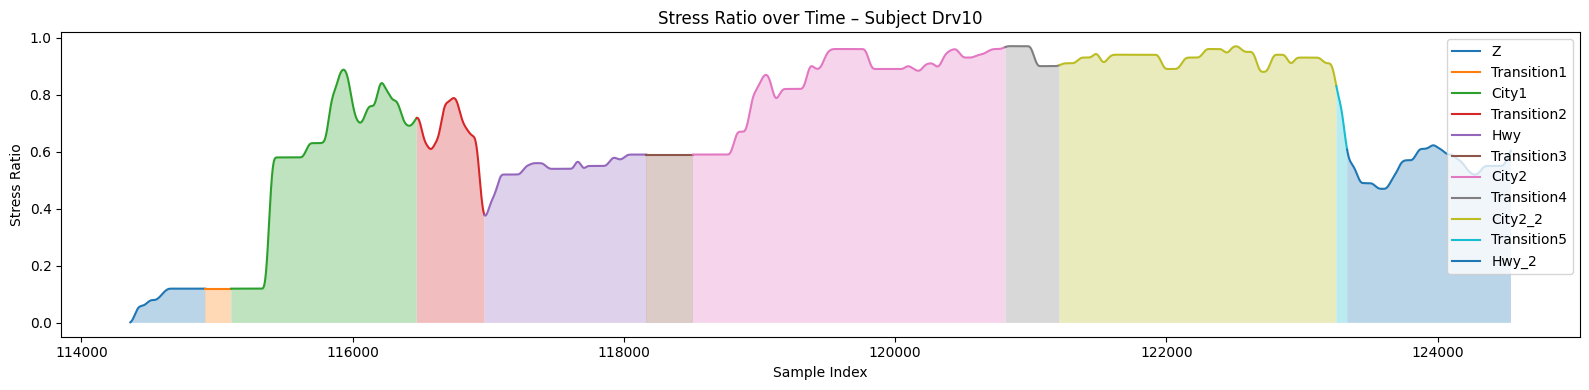

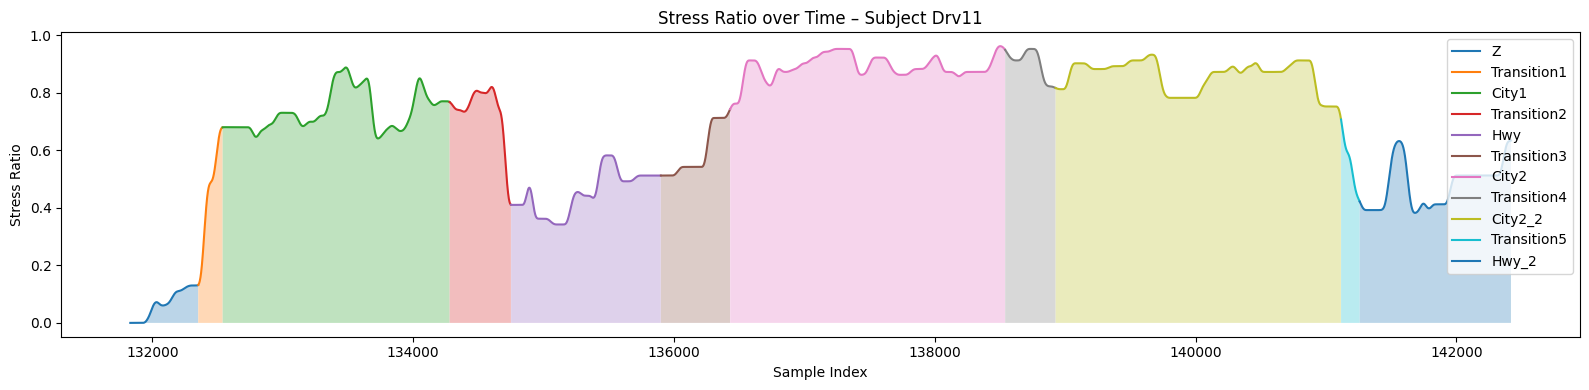

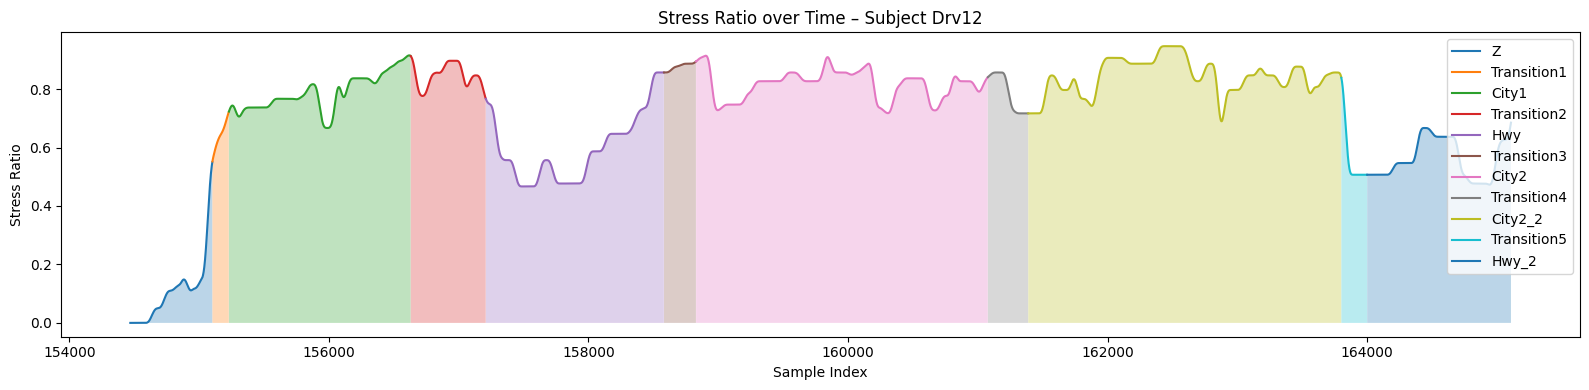

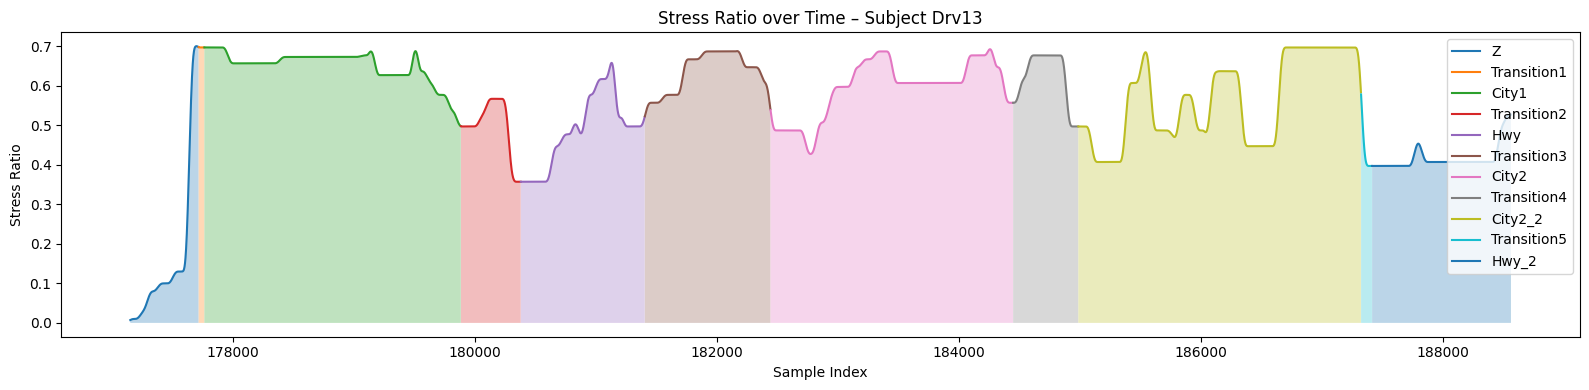

In [ ]:
plot_stress_by_protocol_line(subjective_metrics)

In [ ]:
subjective_metrics.groupby('Subject').size()

,0
Subject,
Drv1,12542
Drv10,12475
Drv11,22274
Drv12,22622
Drv13,22965
Drv2,11756
Drv3,12420
Drv4,16013
Drv5,13581


In [ ]:
def upsample_subjective_metrics_resample(subjective_metrics, df, value_col="stress_ratio"):
    """
    Esegue upsampling tramite duplicazione dei valori (no interpolazione).
    Per ogni soggetto, ripete i valori di `value_col` fino a raggiungere la stessa lunghezza
    dei segnali fisiologici in df.
    """
    upsampled_list = []

    subjects = df['subject'].unique()

    for subject in subjects:
        df_sub = df[df['subject'] == subject]
        sm_sub = subjective_metrics[subjective_metrics['Subject'] == subject]

        len_target = len(df_sub)
        len_source = len(sm_sub)

        if len_target == 0 or len_source == 0:
            print(f"[ATTENZIONE] Soggetto {subject} mancante in uno dei dataset.")
            continue

        # Calcola il numero di ripetizioni necessario per ogni valore
        repeated = np.repeat(sm_sub[value_col].values, np.ceil(len_target / len_source).astype(int))
        repeated = repeated[:len_target]  # Tronca all'esatto numero di sample target

        upsampled_df = pd.DataFrame({
            'subject': [subject] * len_target,
            'upsampled_stress_ratio': repeated
        })

        upsampled_list.append(upsampled_df)

    return pd.concat(upsampled_list, ignore_index=True)

In [ ]:
upsampled_labels = upsample_subjective_metrics_resample(subjective_metrics, df)

In [ ]:
upsampled_labels.groupby('subject').size()

,0
subject,
Drv1,365440
Drv10,572928
Drv11,456384
Drv12,415860
Drv13,436864
Drv2,458688
Drv3,429056
Drv4,412928
Drv5,444768


In [ ]:
df = pd.concat([df.reset_index(drop=True), upsampled_labels["upsampled_stress_ratio"]], axis=1)
df.rename(columns={"upsampled_stress_ratio": "stress_ratio"}, inplace=True)

In [ ]:
df["stress_ratio"] = (df["stress_ratio"] > 0.75).astype(int)
df.rename(columns={"stress_ratio": "label"}, inplace=True)

In [ ]:
df.head()

,acc1,acc2,acc3,bvp,eda,temp,subject,label
0,7.000000,-44.000000,45.000000,-3.439623e-14,3.026075e-15,382.180000,Drv1,0
1,11.999693,-53.519621,44.413727,-1.656125e-14,-2.061213e-01,399.175096,Drv1,0
2,7.000000,-42.000000,46.000000,2.038345e-14,-3.672994e-01,413.836202,Drv1,0
3,-0.196511,-34.550733,47.149869,-3.567041e-14,-4.830911e-01,426.002278,Drv1,0
4,-4.000000,-40.000000,47.000000,-1.273737e-14,-5.540607e-01,435.565582,Drv1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693652 entries, 0 to 5693651
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   acc1     float64
 1   acc2     float64
 2   acc3     float64
 3   bvp      float64
 4   eda      float64
 5   temp     float64
 6   subject  object 
 7   label    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 347.5+ MB


In [ ]:
df.describe()

,acc1,acc2,acc3,bvp,eda,temp,label
count,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06
mean,-2.700631e+01,-1.037054e+01,3.556739e+01,-5.428502e-05,5.320919e+00,3.382515e+01,4.930305e-01
std,2.711127e+01,2.529767e+01,2.585755e+01,9.477823e+01,5.395179e+00,4.445436e+00,4.999515e-01
min,-2.023257e+02,-1.720794e+02,-1.692707e+02,-2.089750e+03,-2.969124e+00,-1.070650e+01,0.000000e+00
25%,-4.807159e+01,-3.000000e+01,2.100000e+01,-2.630000e+01,1.508182e+00,3.228942e+01,0.000000e+00
50%,-2.800000e+01,-9.090761e+00,4.392683e+01,2.130000e+00,3.923683e+00,3.365961e+01,0.000000e+00
75%,-1.200000e+01,5.844741e+00,5.591472e+01,3.016000e+01,6.932137e+00,3.545296e+01,1.000000e+00
max,2.024553e+02,1.745994e+02,1.668622e+02,2.087630e+03,2.802013e+01,4.494678e+02,1.000000e+00


In [ ]:
df['acc_mag'] = np.sqrt(df['acc1']**2+df['acc2']**2+df['acc3']**2)
df = df.drop(columns = ['acc1', 'acc2', 'acc3'], axis = 1)

In [ ]:
df.head()

,bvp,eda,temp,subject,label,acc_mag
0,-3.439623e-14,3.026075e-15,382.180000,Drv1,0,63.324561
1,-1.656125e-14,-2.061213e-01,399.175096,Drv1,0,70.575644
2,2.038345e-14,-3.672994e-01,413.836202,Drv1,0,62.681736
3,-3.567041e-14,-4.830911e-01,426.002278,Drv1,0,58.454272
4,-1.273737e-14,-5.540607e-01,435.565582,Drv1,0,61.846584


In [ ]:
def replace_outliers_with_median(df, columns):
    df_cleaned = df.copy()

    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_val = df_cleaned[col].median()

        outlier_mask = (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
        df_cleaned.loc[outlier_mask, col] = median_val

    return df_cleaned

In [ ]:
columns_to_clean = ['bvp', 'eda', 'temp', 'acc_mag']
df = replace_outliers_with_median(df, columns_to_clean)

In [ ]:
df.describe()

,bvp,eda,temp,label,acc_mag
count,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06
mean,2.273010e+00,4.103463e+00,3.377933e+01,4.930305e-01,6.357901e+01
std,3.981300e+01,3.114999e+00,1.895057e+00,4.999515e-01,2.075574e+00
min,-1.109800e+02,-2.969124e+00,2.754553e+01,0.000000e+00,5.739622e+01
25%,-1.472000e+01,1.508182e+00,3.228969e+01,0.000000e+00,6.258594e+01
50%,2.130000e+00,3.923683e+00,3.365961e+01,0.000000e+00,6.363175e+01
75%,2.120000e+01,6.166415e+00,3.545217e+01,1.000000e+00,6.451972e+01
max,1.148500e+02,1.506790e+01,4.019322e+01,1.000000e+00,6.975897e+01


In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Frequenza Assoluta': freq_assolute,
    'Frequenza Relativa (%)': freq_relative.round(2)*100
})

frequency_table

,Frequenza Assoluta,Frequenza Relativa (%)
label,,
0,2886508,51.0
1,2807144,49.0


In [ ]:
# Raggruppa per soggetto e label
grouped = df.groupby(['subject', 'label']).size().unstack(fill_value=0)

# Calcola totali e percentuali
grouped['Totale'] = grouped[0] + grouped[1]
grouped['% Stress (1)'] = (grouped[1] / grouped['Totale'] * 100).round(2)
grouped['% Baseline (0)'] = (grouped[0] / grouped['Totale'] * 100).round(2)

# Rinomina colonne per chiarezza
grouped.rename(columns={0: 'Baseline (0)', 1: 'Stress (1)'}, inplace=True)

grouped = grouped[['Baseline (0)', 'Stress (1)', 'Totale', '% Baseline (0)', '% Stress (1)']]
grouped

label,Baseline (0),Stress (1),Totale,% Baseline (0),% Stress (1)
subject,,,,,
Drv1,232360,133080,365440,63.58,36.42
Drv10,300884,272044,572928,52.52,47.48
Drv11,315075,141309,456384,69.04,30.96
Drv12,269085,146775,415860,64.71,35.29
Drv13,436864,0,436864,100.00,0.00
Drv2,235568,223120,458688,51.36,48.64
Drv3,191686,237370,429056,44.68,55.32
Drv4,219514,193414,412928,53.16,46.84
Drv5,132060,312708,444768,29.69,70.31


In [ ]:
df.isna().sum()

,0
bvp,0
eda,0
temp,0
subject,0
label,0
acc_mag,0


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 11.0 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["bvp"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['bvp_clean'] = ppg_clean

In [ ]:
from scipy.signal import find_peaks

# Parametri
fs = 64  # frequenza di campionamento
window_sec = 45
overlap = 0.75
window_size = int(fs * window_sec)
step_size = int(window_size * (1 - overlap))

# Lista per raccogliere le feature
features_list = []

# Scorri per finestra
for start in range(0, len(df) - window_size, step_size):
    window = df["bvp_clean"].iloc[start:start + window_size].values
    labels = df["label"].iloc[start:start + window_size].values
    subject = df["subject"].iloc[start]

    # Conta le etichette nella finestra
    counts = np.bincount(labels.astype(int), minlength=2)
    total = counts.sum()
    dominant_label = np.argmax(counts)
    dominant_ratio = counts[dominant_label] / total

    # Scarta la finestra se nessuna classe è predominante almeno al 70%
    if dominant_ratio < 0.7:
        continue

    label = dominant_label  # assegna label predominante

    try:
        # HRV features (NeuroKit2)
        signals, info = nk.ppg_peaks(window, sampling_rate=fs)
        hrv_features = nk.hrv(info, sampling_rate=fs, show=False)

        # --- Time-domain features manuali (Scipy) ---
        peaks, _ = find_peaks(window, distance=fs * 0.5, height=0)
        if len(peaks) < 2:
            raise ValueError("Troppi pochi picchi")

        # Amplitude
        amplitudes = window[peaks]
        amp_mean = np.mean(amplitudes)

        # Rise time
        rise_times = []
        for peak in peaks:
            if peak == 0:
                continue
            min_idx = np.argmin(window[:peak])
            rise_time = (peak - min_idx) / fs
            rise_times.append(rise_time)
        rise_time_mean = np.mean(rise_times)

        # Duration (IBI)
        ibi = np.diff(peaks) / fs
        duration_mean = np.mean(ibi)

        # Inserisci le feature nel DataFrame
        hrv_features["PPG_Amplitude"] = amp_mean
        hrv_features["PPG_RiseTime"] = rise_time_mean
        hrv_features["PPG_Duration"] = duration_mean
        hrv_features["label"] = label
        hrv_features["subject"] = subject

        features_list.append(hrv_features)

    except Exception as e:
        print(f"Errore nella finestra {start}-{start + window_size}: {e}")

# Combina tutte le feature in un unico DataFrame
bvp_features = pd.concat(features_list, ignore_index=True) if features_list else pd.DataFrame()

In [ ]:
print("Shape of BVP Features:",bvp_features.shape)
bvp_features.head()

Shape of BVP Features: (7632, 87)


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,PPG_Amplitude,PPG_RiseTime,PPG_Duration,label,subject
0,710.553279,309.577566,NaN,NaN,NaN,NaN,NaN,NaN,426.746564,430.321903,...,1.047414,1.719088,1.962076,4.262616,1.361153,44.643519,8.243862,0.788068,0,Drv1
1,751.588983,320.738585,NaN,NaN,NaN,NaN,NaN,NaN,466.143074,470.179639,...,1.054656,1.694590,1.991882,5.739203,1.395881,44.375437,6.385776,0.777961,0,Drv1
2,733.854167,310.560276,NaN,NaN,NaN,NaN,NaN,NaN,457.686349,461.611273,...,0.000000,2.241229,2.038067,3.441032,1.279826,47.176623,10.339364,0.792690,0,Drv1
3,782.924107,379.420894,NaN,NaN,NaN,NaN,NaN,NaN,535.117108,539.944968,...,1.129540,2.155693,2.036872,2.544314,1.348136,42.548932,13.783203,0.803125,0,Drv1
4,816.332547,373.229314,NaN,NaN,NaN,NaN,NaN,NaN,529.248918,534.395562,...,1.179625,2.300463,1.969438,2.908859,1.296888,40.036750,14.620815,0.816477,0,Drv1


In [ ]:
bvp_features = bvp_features.replace([np.inf, -np.inf], np.nan)

In [ ]:
# Lista delle feature WESAD da mantenere
wesad_features = [
    'HRV_MeanNN', 'HRV_SDNN', 'HRV_MedianNN', 'HRV_MadNN',
    'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_pNN50', 'HRV_MinNN',
    'HRV_HTI', 'HRV_TINN', 'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Fluctuation',
    'HRV_SampEn', 'HRV_FuzzyEn', 'HRV_MSEn', 'HRV_CD',
    'HRV_HFD', 'HRV_KFD', 'HRV_LZC', 'PPG_Amplitude',
    'PPG_Duration', 'SCR_Peaks_N', 'SCR_Peaks_Amplitude_Mean',
    'AccMag_Mean', 'AccMag_Std', 'AccMag_IQR', 'AccMag_Skew', 'AccMag_Kurtosis',
    'Temp_Mean', 'Temp_Std', 'Temp_Slope'
]

# Funzione di filtro
def filter_features(df, keep_features, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    filtered_cols = [col for col in df.columns if col in keep_features or col in exclude_cols]
    return df[filtered_cols]

In [ ]:
# Esempio di utilizzo su bvp_features
exclude_columns = ['label', 'subject']
bvp_features = filter_features(bvp_features, wesad_features, exclude_columns)

In [ ]:
bvp_features.isna().sum()

,0
HRV_MeanNN,0
HRV_SDNN,0
HRV_MedianNN,0
HRV_MadNN,0
HRV_SDRMSSD,0
HRV_Prc20NN,0
HRV_pNN50,0
HRV_MinNN,0
HRV_HTI,0
HRV_TINN,0


In [ ]:
bvp_features = bvp_features.fillna(bvp_features.median(numeric_only=True))

In [ ]:
sum(bvp_features.isna().sum())

0

In [ ]:
print("Final Shape of BVP Features:", bvp_features.shape)
bvp_features.head()

Final Shape of BVP Features: (7632, 23)


,HRV_MeanNN,HRV_SDNN,HRV_MedianNN,HRV_MadNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_pNN50,HRV_MinNN,HRV_HTI,HRV_TINN,...,HRV_FuzzyEn,HRV_MSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,PPG_Amplitude,PPG_Duration,label,subject
0,710.553279,309.577566,578.1250,277.987500,0.725437,453.125,75.409836,312.50,20.333333,125.000,...,1.511412,1.448244,1.719088,1.962076,4.262616,1.361153,44.643519,0.788068,0,Drv1
1,751.588983,320.738585,671.8750,301.153125,0.688069,478.125,76.271186,312.50,14.750000,265.625,...,1.644480,1.308772,1.694590,1.991882,5.739203,1.395881,44.375437,0.777961,0,Drv1
2,733.854167,310.560276,671.8750,277.987500,0.678544,481.250,86.666667,312.50,15.000000,171.875,...,1.625302,1.286694,2.241229,2.038067,3.441032,1.279826,47.176623,0.792690,0,Drv1
3,782.924107,379.420894,695.3125,312.735937,0.709043,484.375,85.714286,343.75,14.000000,140.625,...,1.405745,1.046119,2.155693,2.036872,2.544314,1.348136,42.548932,0.803125,0,Drv1
4,816.332547,373.229314,765.6250,301.153125,0.705206,512.500,86.792453,343.75,13.250000,453.125,...,1.393031,0.935764,2.300463,1.969438,2.908859,1.296888,40.036750,0.816477,0,Drv1


In [ ]:
eda_raw = df["eda"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['eda_clean'] = eda_clean

In [ ]:
# Parametri
fs = 64  # Frequenza di campionamento
window_sec = 45
overlap = 0.75
window_size = int(fs * window_sec)
step_size = int(window_size * (1 - overlap))

# Lista per raccogliere le feature
eda_features_list = []

# Scorri per finestra
for start in range(0, len(df) - window_size, step_size):
    window_signal = df["eda_clean"].iloc[start:start + window_size].values
    labels = df["label"].iloc[start:start + window_size].values
    subject = df["subject"].iloc[start]

    # Conta le etichette nella finestra
    counts = np.bincount(labels.astype(int), minlength=2)
    total = counts.sum()
    dominant_label = np.argmax(counts)
    dominant_ratio = counts[dominant_label] / total

    # Scarta la finestra se nessuna classe è predominante almeno al 70%
    if dominant_ratio < 0.7:
        continue

    label = dominant_label  # assegna label predominante

    try:
        # Estrai caratteristiche EDA da finestra
        eda_signals, eda_info = nk.eda_peaks(window_signal, sampling_rate=fs)
        features = nk.eda_intervalrelated(eda_signals, sampling_rate=fs)

        # Aggiungi metadati
        features["label"] = label
        features["subject"] = subject

        eda_features_list.append(features)

    except Exception as e:
        print(f"Errore nella finestra {start}-{start + window_size}: {e}")

# Combina tutte le feature in un unico DataFrame
if eda_features_list:
    eda_features = pd.concat(eda_features_list, ignore_index=True)
else:
    print("Nessuna finestra valida.")
    eda_features = pd.DataFrame()

Errore nella finestra 939600-942480: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 940320-943200: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 941040-943920: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 941760-944640: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 1450800-1453680: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 1454400-1457280: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 1455120-1458000: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 1455840-1458720: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 1456560-1459440: zero-size array to reduction operation maximum which has no identity
Errore nella finestra 1457280-146016

In [ ]:
print("Shape of EDA features:", eda_features.shape)
eda_features.head()

Shape of EDA features: (7155, 7)


,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,label,subject
0,16.0,0.653195,NaN,NaN,NaN,0,Drv1
1,18.0,0.590595,NaN,NaN,NaN,0,Drv1
2,18.0,0.556969,NaN,NaN,NaN,0,Drv1
3,14.0,0.502756,NaN,NaN,NaN,0,Drv1
4,8.0,0.763527,NaN,NaN,NaN,0,Drv1


In [ ]:
# Esempio di utilizzo su bvp_features
exclude_columns = ['label', 'subject']
eda_features = filter_features(eda_features, wesad_features, exclude_columns)

In [ ]:
eda_features.isna().sum()

,0
SCR_Peaks_N,0
SCR_Peaks_Amplitude_Mean,3
label,0
subject,0


In [ ]:
eda_features = eda_features.fillna(eda_features.median(numeric_only=True))

In [ ]:
sum(eda_features.isna().sum())

0

In [ ]:
print("Final Shape of EDA Features:", eda_features.shape)
eda_features.head()

Final Shape of EDA Features: (7155, 4)


,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,label,subject
0,16.0,0.653195,0,Drv1
1,18.0,0.590595,0,Drv1
2,18.0,0.556969,0,Drv1
3,14.0,0.502756,0,Drv1
4,8.0,0.763527,0,Drv1


In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
fs = 64
df['acc_mag_clean'] = acc_denoise(df['acc_mag'].values, fs)

In [ ]:
import scipy.signal

# Parametri
fs = 64  # frequenza di campionamento
window_sec = 45
overlap = 0.75
window_size = int(fs * window_sec)
step_size = int(window_size * (1 - overlap))

# Lista per salvare le feature
acc_features_list = []

# Estrai feature per ciascun soggetto
for subject_id in df["subject"].unique():
    print(f"Elaborazione soggetto {subject_id}")
    df_s = df[df["subject"] == subject_id].reset_index(drop=True)

    for start in range(0, len(df_s) - window_size + 1, step_size):
        end = start + window_size
        window = df_s["acc_mag"].iloc[start:end].values
        labels = df_s["label"].iloc[start:end].values

        # Calcolo label dominante
        counts = np.bincount(labels.astype(int), minlength=2)
        total = counts.sum()
        dominant_label = np.argmax(counts)
        dominant_ratio = counts[dominant_label] / total

        # Scarta finestra se non c'è una label predominante
        if dominant_ratio < 0.7:
            continue

        label = dominant_label  # assegna label predominante

        if len(window) == 0:
            continue

        try:
            features = {
                "AccMag_Mean": np.mean(window),
                "AccMag_Std": np.std(window),
                "AccMag_Max": np.max(window),
                "AccMag_Min": np.min(window),
                "AccMag_Range": np.max(window) - np.min(window),
                "AccMag_Median": np.median(window),
                "AccMag_IQR": np.percentile(window, 75) - np.percentile(window, 25),
                "AccMag_Skew": scipy.stats.skew(window),
                "AccMag_Kurtosis": scipy.stats.kurtosis(window),
                "label": label,
                "subject": subject_id,
            }
            acc_features_list.append(features)

        except Exception as e:
            print(f"Errore finestra {start}-{end}: {e}")
            continue

# Combina le feature in un DataFrame
acc_features = pd.DataFrame(acc_features_list)

Elaborazione soggetto Drv1
Elaborazione soggetto Drv10
Elaborazione soggetto Drv11
Elaborazione soggetto Drv12
Elaborazione soggetto Drv13
Elaborazione soggetto Drv2
Elaborazione soggetto Drv3
Elaborazione soggetto Drv4
Elaborazione soggetto Drv5
Elaborazione soggetto Drv6
Elaborazione soggetto Drv7
Elaborazione soggetto Drv8
Elaborazione soggetto Drv9


In [ ]:
print("Shape of ACC Features", acc_features.shape)
acc_features.head()

Shape of ACC Features (7603, 11)


,AccMag_Mean,AccMag_Std,AccMag_Max,AccMag_Min,AccMag_Range,AccMag_Median,AccMag_IQR,AccMag_Skew,AccMag_Kurtosis,label,subject
0,63.675116,1.753461,69.756720,57.455101,12.301619,63.631753,1.342501,-0.060097,1.973310,0,Drv1
1,63.838161,1.784092,69.756720,57.455101,12.301619,63.859220,1.416685,-0.250134,1.994800,0,Drv1
2,63.950402,1.678886,69.734938,57.455101,12.279837,64.023119,1.350960,-0.275422,2.362752,0,Drv1
3,64.130517,1.520972,69.734938,57.400810,12.334128,64.374167,1.059823,-0.510702,3.426006,0,Drv1
4,64.062893,1.379024,69.734938,57.400810,12.334128,64.317129,1.139093,-0.438041,4.191910,0,Drv1


In [ ]:
# Esempio di utilizzo su bvp_features
exclude_columns = ['label', 'subject']
acc_features = filter_features(acc_features, wesad_features, exclude_columns)

In [ ]:
acc_features.isna().sum()

,0
AccMag_Mean,0
AccMag_Std,0
AccMag_IQR,0
AccMag_Skew,0
AccMag_Kurtosis,0
label,0
subject,0


In [ ]:
print("Final Shape of ACC Features:", acc_features.shape)
acc_features.head()

Final Shape of ACC Features: (7603, 7)


,AccMag_Mean,AccMag_Std,AccMag_IQR,AccMag_Skew,AccMag_Kurtosis,label,subject
0,63.675116,1.753461,1.342501,-0.060097,1.973310,0,Drv1
1,63.838161,1.784092,1.416685,-0.250134,1.994800,0,Drv1
2,63.950402,1.678886,1.350960,-0.275422,2.362752,0,Drv1
3,64.130517,1.520972,1.059823,-0.510702,3.426006,0,Drv1
4,64.062893,1.379024,1.139093,-0.438041,4.191910,0,Drv1


In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['temp_clean'] = temp_denoise(df['temp'].values, fs)

In [ ]:
# Parametri
fs = 64  # frequenza di campionamento
window_sec = 45
overlap = 0.75
window_size = int(window_sec * fs)
step_size = int(window_size * (1 - overlap))

# Lista per raccogliere le feature
features_list = []

# Estrazione feature per ogni finestra
for start in range(0, len(df) - window_size + 1, step_size):
    end = start + window_size
    window_signal = df["temp_clean"].iloc[start:end].values
    window_labels = df["label"].iloc[start:end].values
    window_subject = df["subject"].iloc[start]

    # Conta le etichette nella finestra
    counts = np.bincount(window_labels.astype(int), minlength=2)
    total = counts.sum()
    dominant_label = np.argmax(counts)
    dominant_ratio = counts[dominant_label] / total

    # Scarta la finestra se nessuna classe è predominante almeno al 70%
    if dominant_ratio < 0.7:
        continue

    label = dominant_label  # assegna la label predominante

    try:
        mean_val = np.mean(window_signal)
        std_val = np.std(window_signal)
        min_val = np.min(window_signal)
        max_val = np.max(window_signal)
        slope = np.polyfit(np.arange(len(window_signal)), window_signal, 1)[0]

        features = {
            "Temp_Mean": mean_val,
            "Temp_Std": std_val,
            "Temp_Min": min_val,
            "Temp_Max": max_val,
            "Temp_Slope": slope,
            "label": label,
            "subject": window_subject
        }

        features_list.append(features)

    except Exception as e:
        print(f"Errore nella finestra {start}-{end}: {e}")
        continue

# Combina tutte le feature in un DataFrame
if features_list:
    temp_features = pd.DataFrame(features_list)
else:
    print("Nessuna finestra valida.")
    temp_features = pd.DataFrame()

In [ ]:
print("Shape of TEMP Features", temp_features.shape)
temp_features.head()

Shape of TEMP Features (7632, 7)


,Temp_Mean,Temp_Std,Temp_Min,Temp_Max,Temp_Slope,label,subject
0,34.567779,0.180110,33.663248,34.720545,0.000053,0,Drv1
1,34.590669,0.023607,34.547711,34.637693,-0.000024,0,Drv1
2,34.582939,0.018575,34.547711,34.629319,-0.000008,0,Drv1
3,34.584556,0.020080,34.547711,34.635288,0.000015,0,Drv1
4,34.591416,0.020886,34.547711,34.635978,0.000018,0,Drv1


In [ ]:
# Esempio di utilizzo su bvp_features
exclude_columns = ['label', 'subject']
temp_features = filter_features(temp_features, wesad_features, exclude_columns)

In [ ]:
temp_features.isna().sum()

,0
Temp_Mean,0
Temp_Std,0
Temp_Slope,0
label,0
subject,0


In [ ]:
print("Final Shape of TEMP Features:", temp_features.shape)
temp_features.head()

Final Shape of TEMP Features: (7632, 5)


,Temp_Mean,Temp_Std,Temp_Slope,label,subject
0,34.567779,0.180110,0.000053,0,Drv1
1,34.590669,0.023607,-0.000024,0,Drv1
2,34.582939,0.018575,-0.000008,0,Drv1
3,34.584556,0.020080,0.000015,0,Drv1
4,34.591416,0.020886,0.000018,0,Drv1


In [ ]:
print("Final Shape of BVP Features:", bvp_features.shape)
print("Final Shape of EDA Features:", eda_features.shape)
print("Final Shape of ACC Features:", acc_features.shape)
print("Final Shape of TEMP Features:", temp_features.shape)

Final Shape of BVP Features: (7632, 23)
Final Shape of EDA Features: (7155, 4)
Final Shape of ACC Features: (7603, 7)
Final Shape of TEMP Features: (7632, 5)


In [ ]:
# Trova la lunghezza minima
min_len = min(len(bvp_features), len(eda_features), len(acc_features), len(temp_features))

# Troncamento e reindicizzazione
bvp_trimmed = bvp_features.iloc[:min_len].reset_index(drop=True)
eda_trimmed = eda_features.iloc[:min_len].reset_index(drop=True)
acc_trimmed = acc_features.iloc[:min_len].reset_index(drop=True)
temp_trimmed = temp_features.iloc[:min_len].reset_index(drop=True)

# Verifica che le colonne label e subject siano allineate
# Se presenti in ogni dataframe, tienile solo da uno (es: da bvp_trimmed)
eda_trimmed = eda_trimmed.drop(columns=['label', 'subject'], errors='ignore')
acc_trimmed = acc_trimmed.drop(columns=['label', 'subject'], errors='ignore')
temp_trimmed = temp_trimmed.drop(columns=['label', 'subject'], errors='ignore')

# Concatenazione finale
all_features = pd.concat([bvp_trimmed, eda_trimmed, acc_trimmed, temp_trimmed], axis=1)

# Controllo dimensioni
print("Final shape of concatenated dataset:", all_features.shape)

Final shape of concatenated dataset: (7155, 33)


In [ ]:
all_features.head()

,HRV_MeanNN,HRV_SDNN,HRV_MedianNN,HRV_MadNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_pNN50,HRV_MinNN,HRV_HTI,HRV_TINN,...,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,AccMag_Mean,AccMag_Std,AccMag_IQR,AccMag_Skew,AccMag_Kurtosis,Temp_Mean,Temp_Std,Temp_Slope
0,710.553279,309.577566,578.1250,277.987500,0.725437,453.125,75.409836,312.50,20.333333,125.000,...,16.0,0.653195,63.675116,1.753461,1.342501,-0.060097,1.973310,34.567779,0.180110,0.000053
1,751.588983,320.738585,671.8750,301.153125,0.688069,478.125,76.271186,312.50,14.750000,265.625,...,18.0,0.590595,63.838161,1.784092,1.416685,-0.250134,1.994800,34.590669,0.023607,-0.000024
2,733.854167,310.560276,671.8750,277.987500,0.678544,481.250,86.666667,312.50,15.000000,171.875,...,18.0,0.556969,63.950402,1.678886,1.350960,-0.275422,2.362752,34.582939,0.018575,-0.000008
3,782.924107,379.420894,695.3125,312.735937,0.709043,484.375,85.714286,343.75,14.000000,140.625,...,14.0,0.502756,64.130517,1.520972,1.059823,-0.510702,3.426006,34.584556,0.020080,0.000015
4,816.332547,373.229314,765.6250,301.153125,0.705206,512.500,86.792453,343.75,13.250000,453.125,...,8.0,0.763527,64.062893,1.379024,1.139093,-0.438041,4.191910,34.591416,0.020886,0.000018


In [ ]:
# Percorso per formato CSV
save_path_csv = "/content/drive/MyDrive/CROSS TEST/DATASET/AFFECTIVEROADDATASET_E4_45SEC_75OL.csv"

# Salvataggio in CSV
all_features.to_csv(save_path_csv, index=False)

print(f"Dataset salvato in formato CSV in: {save_path_csv}")

Dataset salvato in formato CSV in: /content/drive/MyDrive/CROSS TEST/DATASET/AFFECTIVEROADDATASET_E4_45SEC_75OL.csv
